# Rice Image Classification

## Imports

In [31]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import keras_tuner as kt
import sklearn 
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Working with Predetermined Feature Set

### Data Ingestion

In [32]:
df = pd.read_excel('./Rice_MSC_Dataset.xlsx')
df.head(5)

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,ALLdaub4L,ALLdaub4a,ALLdaub4b,ALLdaub4Y,ALLdaub4Cb,ALLdaub4Cr,ALLdaub4XX,ALLdaub4YY,ALLdaub4ZZ,CLASS
0,7805,437.915,209.8215,48.0221,0.9735,99.6877,0.9775,7985,0.3547,4.3693,...,113.9924,65.0610,59.5989,104.8552,67.8779,63.0828,0.3673,0.3793,0.4733,Basmati
1,7503,340.757,138.3361,69.8417,0.8632,97.7400,0.9660,7767,0.6637,1.9807,...,105.7055,64.3685,62.2084,96.8375,65.5371,63.5832,0.3014,0.3144,0.3641,Arborio
2,5124,314.617,141.9803,46.5784,0.9447,80.7718,0.9721,5271,0.4760,3.0482,...,109.7155,62.6423,58.7439,100.2352,68.9753,59.8342,0.3233,0.3445,0.4448,Jasmine
3,7990,437.085,201.4386,51.2245,0.9671,100.8622,0.9659,8272,0.6274,3.9325,...,116.5405,64.9069,60.2562,107.2560,67.3298,63.2237,0.3880,0.4020,0.4904,Basmati
4,7433,342.893,140.3350,68.3927,0.8732,97.2830,0.9831,7561,0.6006,2.0519,...,107.7502,64.7071,61.3549,98.8704,66.2048,63.5378,0.3184,0.3303,0.3928,Arborio


In [33]:
# basic facts about the data 

print(f'Number of Columns: {df.shape[1]}')
print(f'Number of Rows: {df.shape[0]}')

Number of Columns: 107
Number of Rows: 75000


### Feature Engineering

In [34]:
# shuffling 

np.random.seed(0) # putting seed here so in same cell as the random function 

indices = list(df.index)
shuffled_indices = np.random.permutation(indices)

df = df.reindex(shuffled_indices)
df.head(5)

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,ALLdaub4L,ALLdaub4a,ALLdaub4b,ALLdaub4Y,ALLdaub4Cb,ALLdaub4Cr,ALLdaub4XX,ALLdaub4YY,ALLdaub4ZZ,CLASS
69870,13113,461.388,191.1680,88.3067,0.8869,129.2130,0.9760,13436,0.5887,2.1648,...,120.8948,63.3202,64.9225,110.8884,63.2070,63.5551,0.4108,0.4367,0.4612,Ipsala
67768,8418,351.864,143.8394,74.7980,0.8542,103.5284,0.9857,8540,0.6733,1.9230,...,114.1070,64.4193,63.2270,104.7550,64.7384,64.1449,0.3641,0.3804,0.4260,Arborio
36749,8027,452.120,213.9190,49.3758,0.9730,101.0955,0.9586,8374,0.5873,4.3325,...,113.9102,64.9424,59.9561,104.7468,67.5794,63.1647,0.3661,0.3785,0.4674,Basmati
16324,5185,279.813,116.3443,56.9430,0.8720,81.2511,0.9813,5284,0.7450,2.0432,...,106.1725,64.6719,62.9395,97.3271,64.9179,64.3227,0.3066,0.3189,0.3612,Karacadag
23085,14321,480.033,198.7702,92.7677,0.8844,135.0336,0.9822,14580,0.8210,2.1427,...,119.3267,63.9888,64.6205,109.5653,63.4112,64.2545,0.4025,0.4240,0.4529,Ipsala


In [35]:
# train-test split 60-20-20 

X = df.drop(columns = ['CLASS'], axis = 1)
Y = df[['CLASS']]
Y['CLASS'] = pd.factorize(Y['CLASS'])[0] # assign the class names numeric values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1234) # want 80% train for later 60-20 train-val split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 1234) # 0.25 * .80 = 0.2

/var/folders/s0/ptxvxh691ggcgy97w_d3rm6w0000gn/T/ipykernel_42123/223748310.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['CLASS'] = pd.factorize(Y['CLASS'])[0] # assign the class names numeric values


In [36]:
# remove missing values since number of missing values is so small 

print(f' Number of missing feature values in training data: {sum(X_train.isna().sum())}')
print(f' Number of missing outcome values in training data: {Y_train.isna().sum()[0]}')
print(f' Number of missing feature values in test data: {sum(X_test.isna().sum())}')
print(f' Number of missing outcome values in test data: {Y_test.isna().sum()[0]}')
print(f' Number of missing feature values in validation data: {sum(X_val.isna().sum())}')
print(f' Number of missing outcome values in validation data: {Y_val.isna().sum()[0]}')

X_train.dropna()
X_val.dropna()

Y_train = Y_train[Y_train.index.isin(X_train.index)]
Y_val = Y_val[Y_val.index.isin(X_val.index)]

 Number of missing feature values in training data: 16
 Number of missing outcome values in training data: 0
 Number of missing feature values in test data: 0
 Number of missing outcome values in test data: 0
 Number of missing feature values in validation data: 6
 Number of missing outcome values in validation data: 0


/var/folders/s0/ptxvxh691ggcgy97w_d3rm6w0000gn/T/ipykernel_42123/277861001.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f' Number of missing outcome values in training data: {Y_train.isna().sum()[0]}')
/var/folders/s0/ptxvxh691ggcgy97w_d3rm6w0000gn/T/ipykernel_42123/277861001.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f' Number of missing outcome values in test data: {Y_test.isna().sum()[0]}')
/var/folders/s0/ptxvxh691ggcgy97w_d3rm6w0000gn/T/ipykernel_42123/277861001.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

In [37]:
# feature selection - getting rid of redundant features

# want to get rid of high multicollinearity (r > 0.8) 

X_train_corr = X_train.corr()
multicoll_mat = X_train_corr[(X_train_corr.abs() >= 0.8) & (X_train_corr.abs() < 1)] # every column has r = 1 w/ itself 

multicoll_cols = set()

for col in multicoll_mat.columns:
    correlated_columns = multicoll_mat[col].dropna().index
    multicoll_cols.update(correlated_columns)   

X_train = X_train.drop(columns = list(multicoll_cols), axis = 1)
X_test = X_test.drop(columns = list(multicoll_cols), axis = 1)
X_val = X_val.drop(columns = list(multicoll_cols), axis = 1)

print(multicoll_cols)
print(f'Number of Remaining Columns: {len(multicoll_cols)}')

{'entropyCr', 'SHAPEFACTOR_1', 'skewCb', 'entropyYY', 'entropyRG', 'ALLdaub4a', 'entropyCb', 'StdDevS', 'entropyXX', 'ASPECT_RATIO', 'StdDevRG', 'skewYY', 'ALLdaub4Cr', 'meanCb', 'kurtosisXX', 'StdDevCb', 'PERIMETER', 'ALLdaub4Y', 'EQDIASQ', 'kurtosisCr', 'StdDevXX', 'meanL', 'StdDevV', 'ECCENTRICITY', 'CONVEX_AREA', 'kurtosisYY', 'skewRB', 'ALLdaub4V', 'meanRR', 'kurtosisB', 'meanY', 'entropyRB', 'meanV', 'StdDevRB', 'skewRG', 'ALLdaub4Cb', 'meanCr', 'entropyA', 'MINOR_AXIS', 'meanH', 'skewB', 'ALLdaub4S', 'SHAPEFACTOR_3', 'skewL', 'skewY', 'kurtosisZZ', 'StdDevL', 'ALLdaub4YY', 'kurtosisS', 'AREA', 'kurtosisV', 'kurtosisL', 'entropyZZ', 'meanS', 'MAJOR_AXIS', 'entropyV', 'COMPACTNESS', 'kurtosisRR', 'entropyRR', 'StdDevB', 'skewZZ', 'ALLdaub4H', 'SHAPEFACTOR_2', 'meanZZ', 'skewXX', 'meanXX', 'StdDevY', 'ALLdaub4b', 'skewV', 'meanRB', 'ALLdaub4RB', 'meanA', 'entropyL', 'kurtosisRG', 'ALLdaub4ZZ', 'ROUNDNESS', 'skewRR', 'StdDevYY', 'kurtosisY', 'kurtosisCb', 'entropyB', 'StdDevZZ', 'me

In [38]:
# normalizing features for easier scaling - no other transformation needed since all variables are numeric 

X_train_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test_norm = (X_test - X_test.min()) / (X_test.max() - X_test.min())
X_val_norm = (X_val - X_val.min()) / (X_val.max() - X_val.min())

### Baseline Model

In [39]:
# using majority class model 

majority_class = Y_train.value_counts().idxmax()[0] # finds the majority class 
majority_class_pred = np.full(len(Y_train), majority_class) # np.full fills an array of values (majority_class) at a given length 
majority_class_accuracy = np.mean(majority_class_pred == Y_train.values) # flatten values to get same dimensions
print(f'Majority Class: {majority_class}')
print(f'Majority Class Baseline Accuracy: {majority_class_accuracy}')

Majority Class: 0
Majority Class Baseline Accuracy: 0.2018


In [40]:
# why low accuracy? We have good class balance 

Y_train.value_counts()

CLASS
0        9081
2        9026
4        8993
1        8953
3        8947
Name: count, dtype: int64

In [41]:
# include CE loss for the baseline model for completeness

def multiclass_cross_entropy(y, y_pred):
    """
    Computes categorical cross-entropy loss.

    Args:
    y_true: NumPy array of true labels (one-hot encoded).
    y_pred: NumPy array of predicted probabilities.

    Returns:
    Multi-class cross-entropy loss.
    """
    
    y = np.array(y)
    y_pred = np.array(y_pred)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) # ensures no log(0) values 
    loss = -np.sum(y * np.log(y_pred))
    return loss

baseline_loss = multiclass_cross_entropy(Y_train, majority_class_pred)
print(f'Baseline Model Loss: {baseline_loss}')

Baseline Model Loss: 139599171820.3884


Random Forest / XGBoost


===== Random Forest Classifier =====
Random Forest Training Accuracy: 0.9466
Random Forest Validation Accuracy: 0.8476
Random Forest Test Accuracy: 0.7669

Random Forest Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2908
           1       0.83      0.92      0.87      3047
           2       0.88      0.75      0.81      2990
           3       0.98      0.71      0.82      2986
           4       0.72      0.88      0.80      3069

    accuracy                           0.85     15000
   macro avg       0.86      0.85      0.85     15000
weighted avg       0.86      0.85      0.85     15000



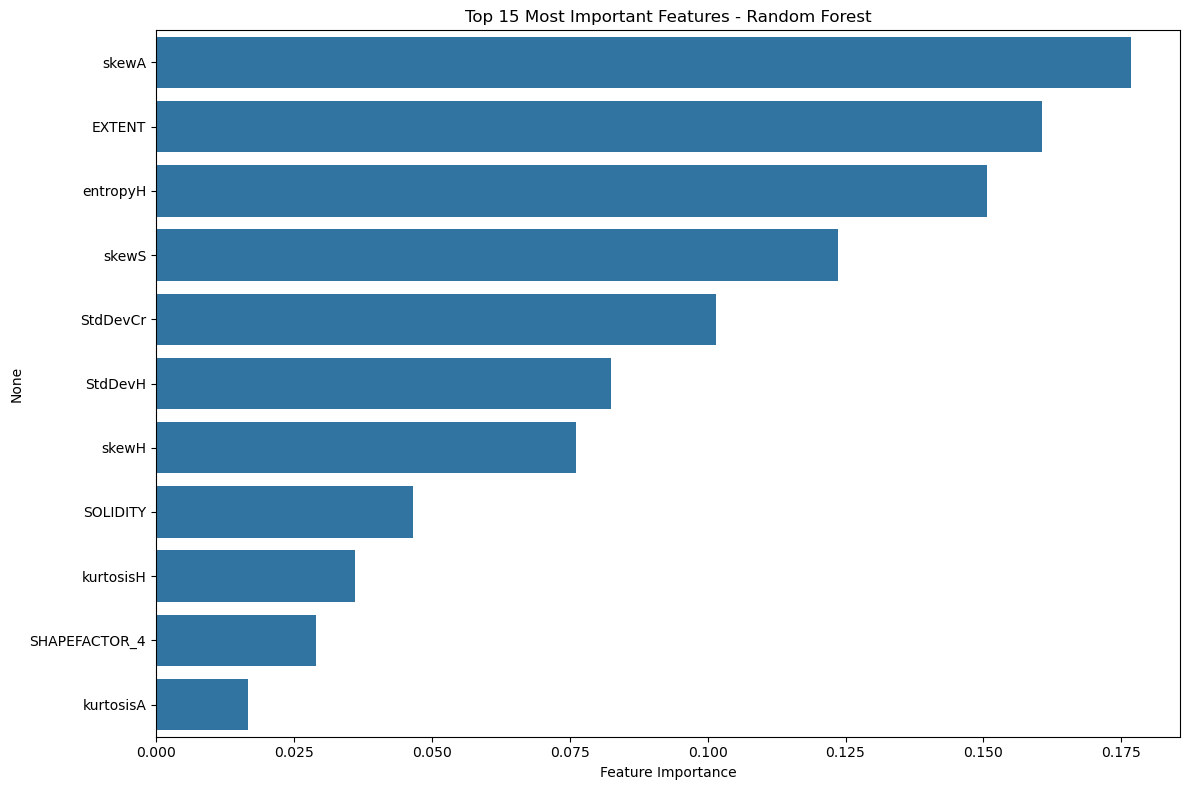

In [65]:
print("\n===== Random Forest Classifier =====")

# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=50, 
    max_depth=6,   
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt', 
    bootstrap=True,
    random_state=1234,
    n_jobs=-1 
)


rf_model.fit(X_train_norm, Y_train.values.ravel())

rf_train_pred = rf_model.predict(X_train_norm)
rf_val_pred = rf_model.predict(X_val_norm)
rf_test_pred = rf_model.predict(X_test_norm)

rf_train_acc = accuracy_score(Y_train, rf_train_pred)
rf_val_acc = accuracy_score(Y_val, rf_val_pred)
rf_test_acc = accuracy_score(Y_test, rf_test_pred)

print(f"Random Forest Training Accuracy: {rf_train_acc:.4f}")
print(f"Random Forest Validation Accuracy: {rf_val_acc:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")


print("\nRandom Forest Classification Report (Validation Set):")
print(classification_report(Y_val, rf_val_pred))


plt.figure(figsize=(12, 8))
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_15_features = feature_importances.nlargest(15)
sns.barplot(x=top_15_features.values, y=top_15_features.index)
plt.title('Top 15 Most Important Features - Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()



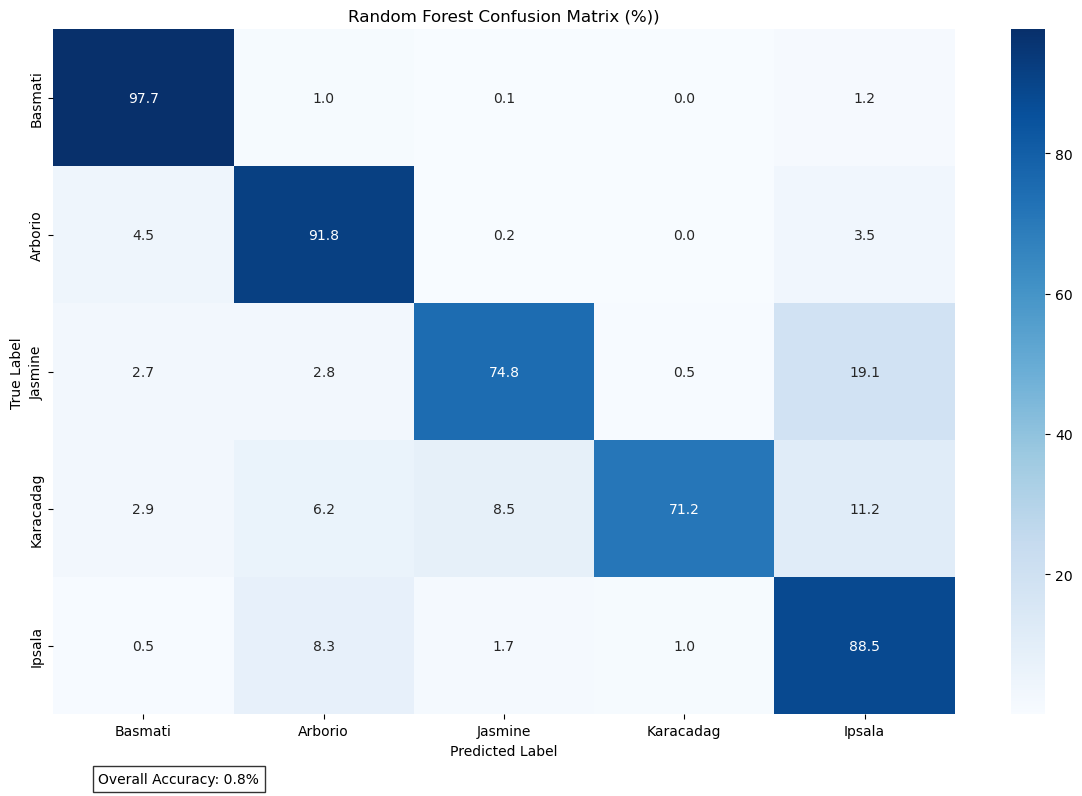


Confusion Matrix Analysis:
Number of correct predictions: 12714
Total predictions: 15000
Overall accuracy: 0.8%

Per-class Performance:

Basmati:
Precision: 89.8%
Recall: 97.7%

Arborio:
Precision: 83.4%
Recall: 91.8%

Jasmine:
Precision: 87.7%
Recall: 74.8%

Karacadag:
Precision: 97.8%
Recall: 71.2%

Ipsala:
Precision: 72.2%
Recall: 88.5%


In [66]:

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_val, rf_val_pred)

plt.figure(figsize=(12, 8))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_percent, 
            annot=True,
            fmt='.1f',
            cmap='Blues',
            xticklabels=['Basmati', 'Arborio', 'Jasmine', 'Karacadag', 'Ipsala'],
            yticklabels=['Basmati', 'Arborio', 'Jasmine', 'Karacadag', 'Ipsala'])

plt.title('Random Forest Confusion Matrix (%))')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

overall_accuracy = np.trace(cm_percent) / np.sum(cm_percent)
plt.text(0.05, -0.1, f'Overall Accuracy: {overall_accuracy:.1f}%', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Analysis:")
print(f"Number of correct predictions: {np.trace(cm)}")
print(f"Total predictions: {np.sum(cm)}")
print(f"Overall accuracy: {overall_accuracy:.1f}%")

print("\nPer-class Performance:")
for i, rice_type in enumerate(['Basmati', 'Arborio', 'Jasmine', 'Karacadag', 'Ipsala']):
    precision = cm[i,i] / cm[:,i].sum() * 100
    recall = cm[i,i] / cm[i,:].sum() * 100
    print(f"\n{rice_type}:")
    print(f"Precision: {precision:.1f}%")
    print(f"Recall: {recall:.1f}%")

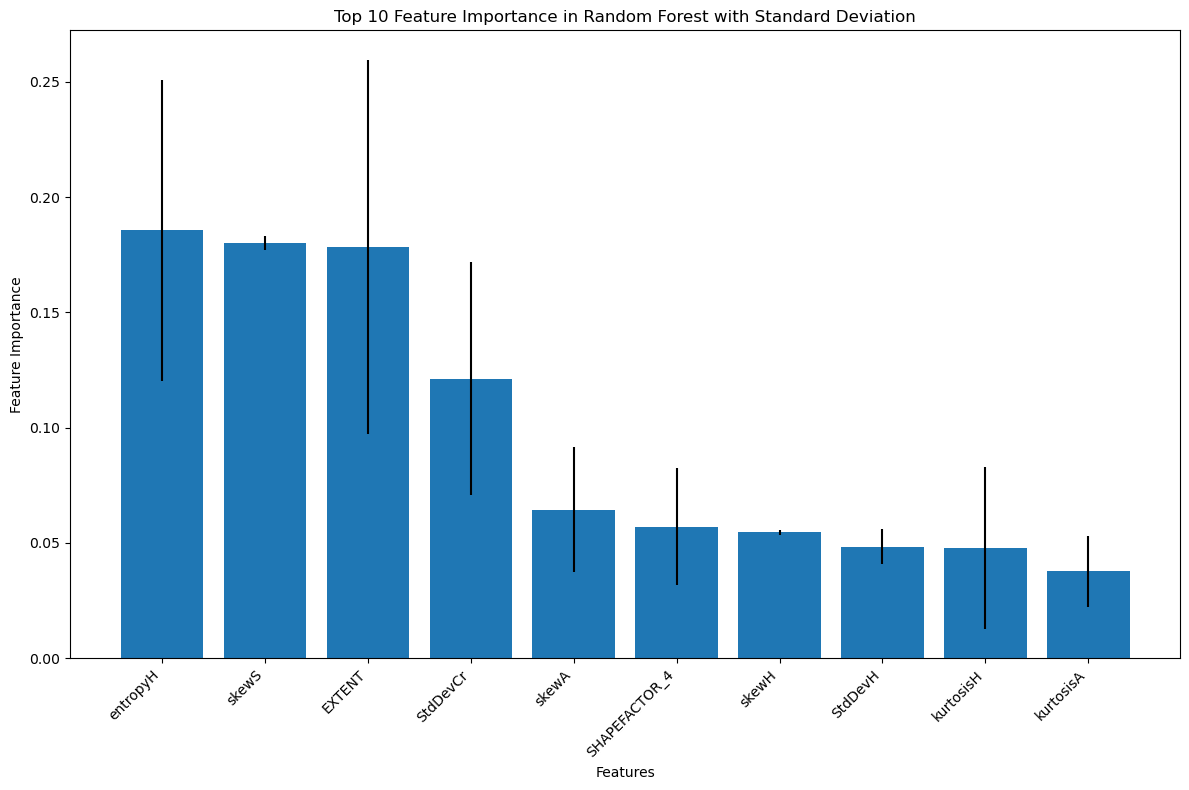

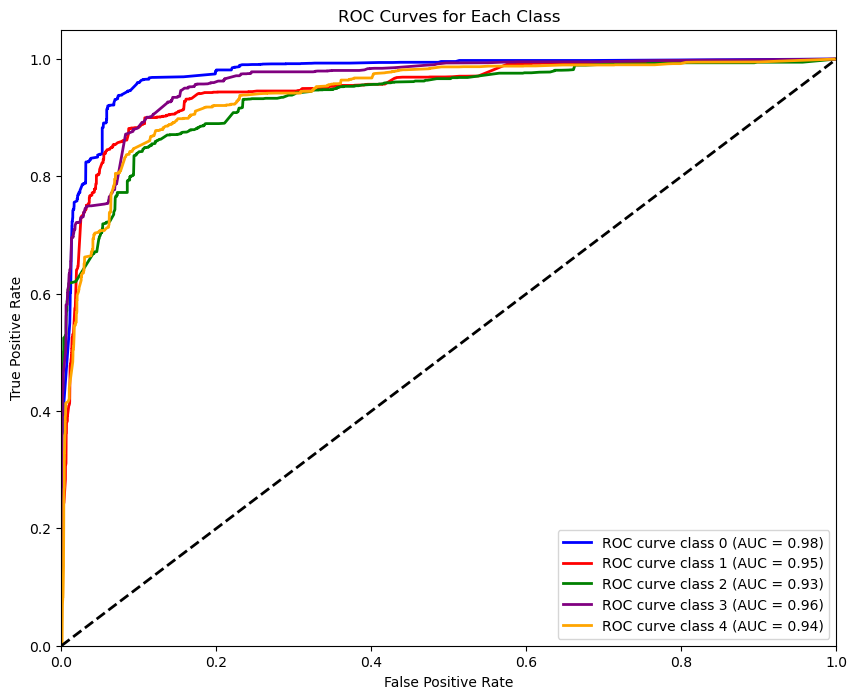

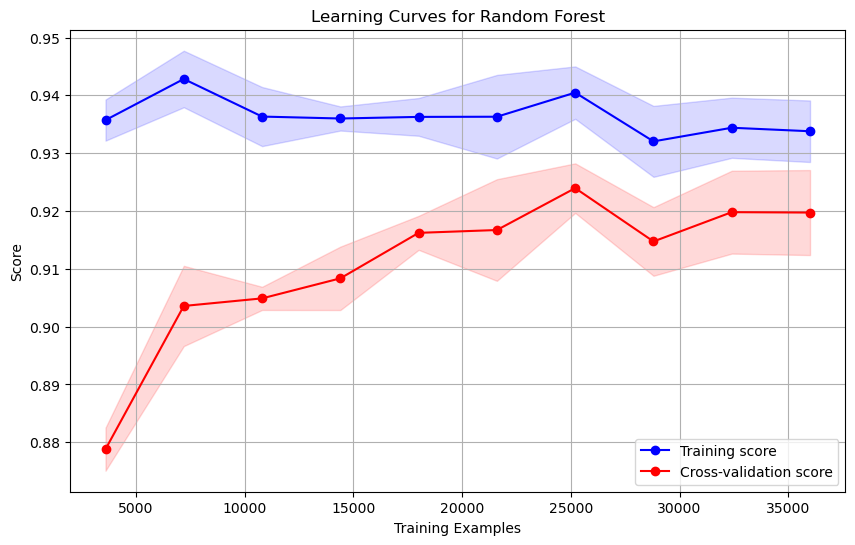

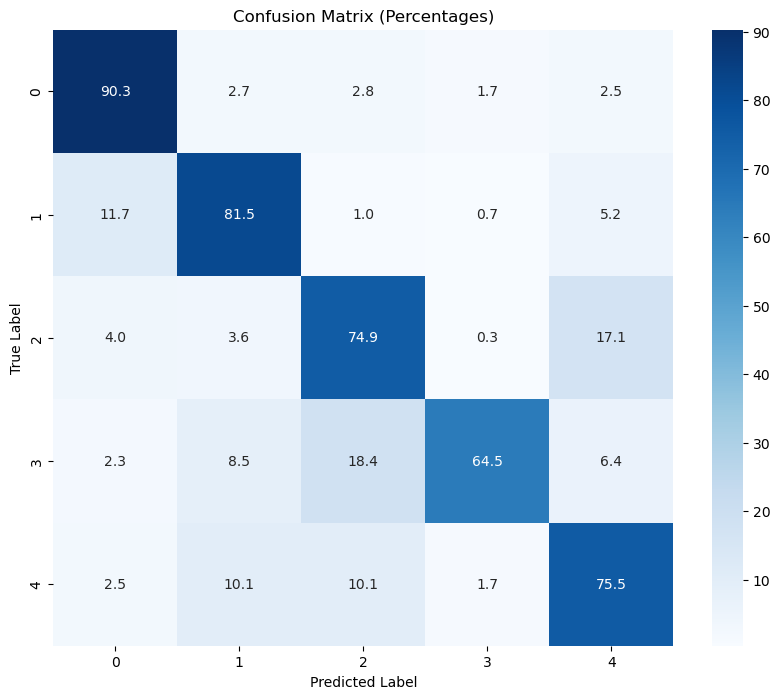

In [57]:
from sklearn.model_selection import learning_curve
plt.figure(figsize=(12, 8))
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

n_features = len(importances)
n_features_to_plot = min(n_features, 10) 

indices = np.argsort(importances)[::-1][:n_features_to_plot]

plt.bar(range(n_features_to_plot), importances[indices], yerr=std[indices], align='center')
plt.xticks(range(n_features_to_plot), X_train.columns[indices], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title(f'Top {n_features_to_plot} Feature Importance in Random Forest with Standard Deviation')
plt.tight_layout()
plt.show()


from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_val_bin = label_binarize(Y_val, classes=np.unique(Y_val))
y_pred_proba = rf_model.predict_proba(X_val_norm)

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(5), colors):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train_norm, Y_train.values.ravel(),
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, n_jobs=-1)

plt.figure(figsize=(10, 6))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, label='Cross-validation score', color='red', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')

plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves for Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_val, rf_val_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


===== XGBoost Classifier =====
XGBoost Training Accuracy: 0.9862
XGBoost Validation Accuracy: 0.8815
XGBoost Test Accuracy: 0.8579

XGBoost Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2908
           1       0.84      0.94      0.89      3047
           2       0.80      0.89      0.85      2990
           3       0.99      0.70      0.82      2986
           4       0.90      0.89      0.90      3069

    accuracy                           0.88     15000
   macro avg       0.89      0.88      0.88     15000
weighted avg       0.89      0.88      0.88     15000



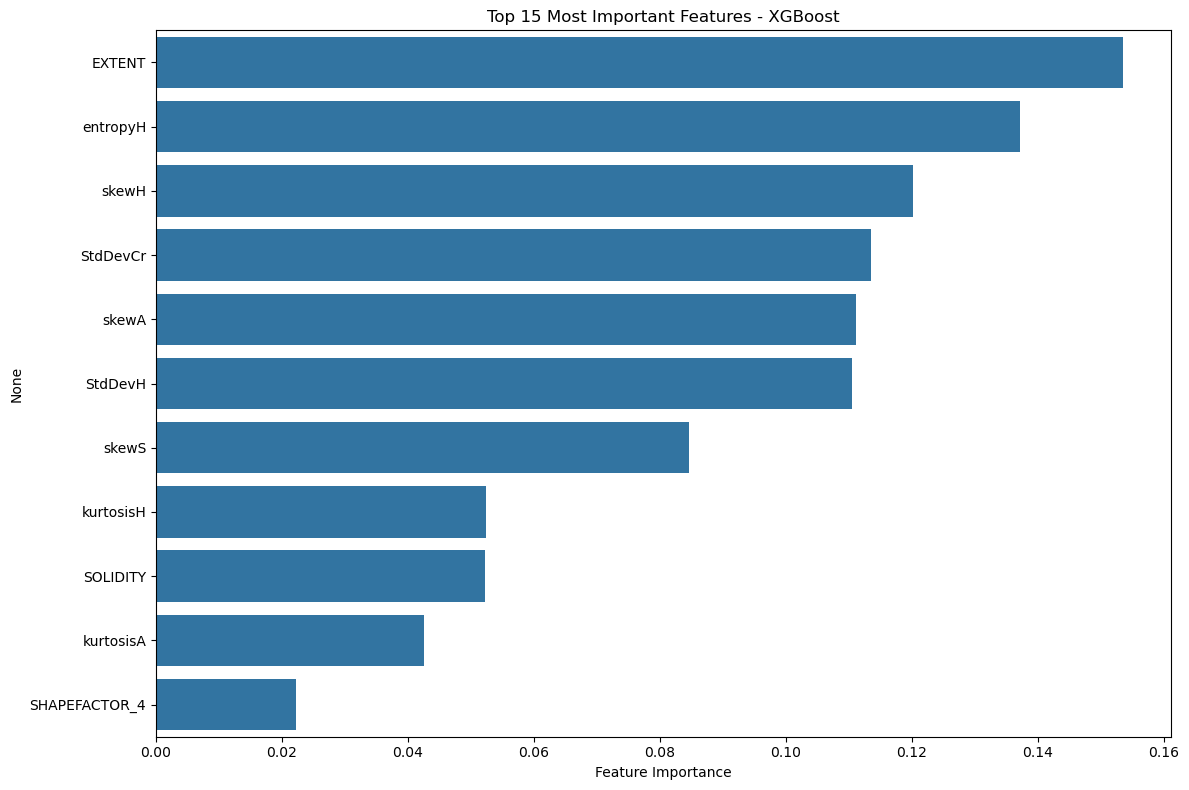

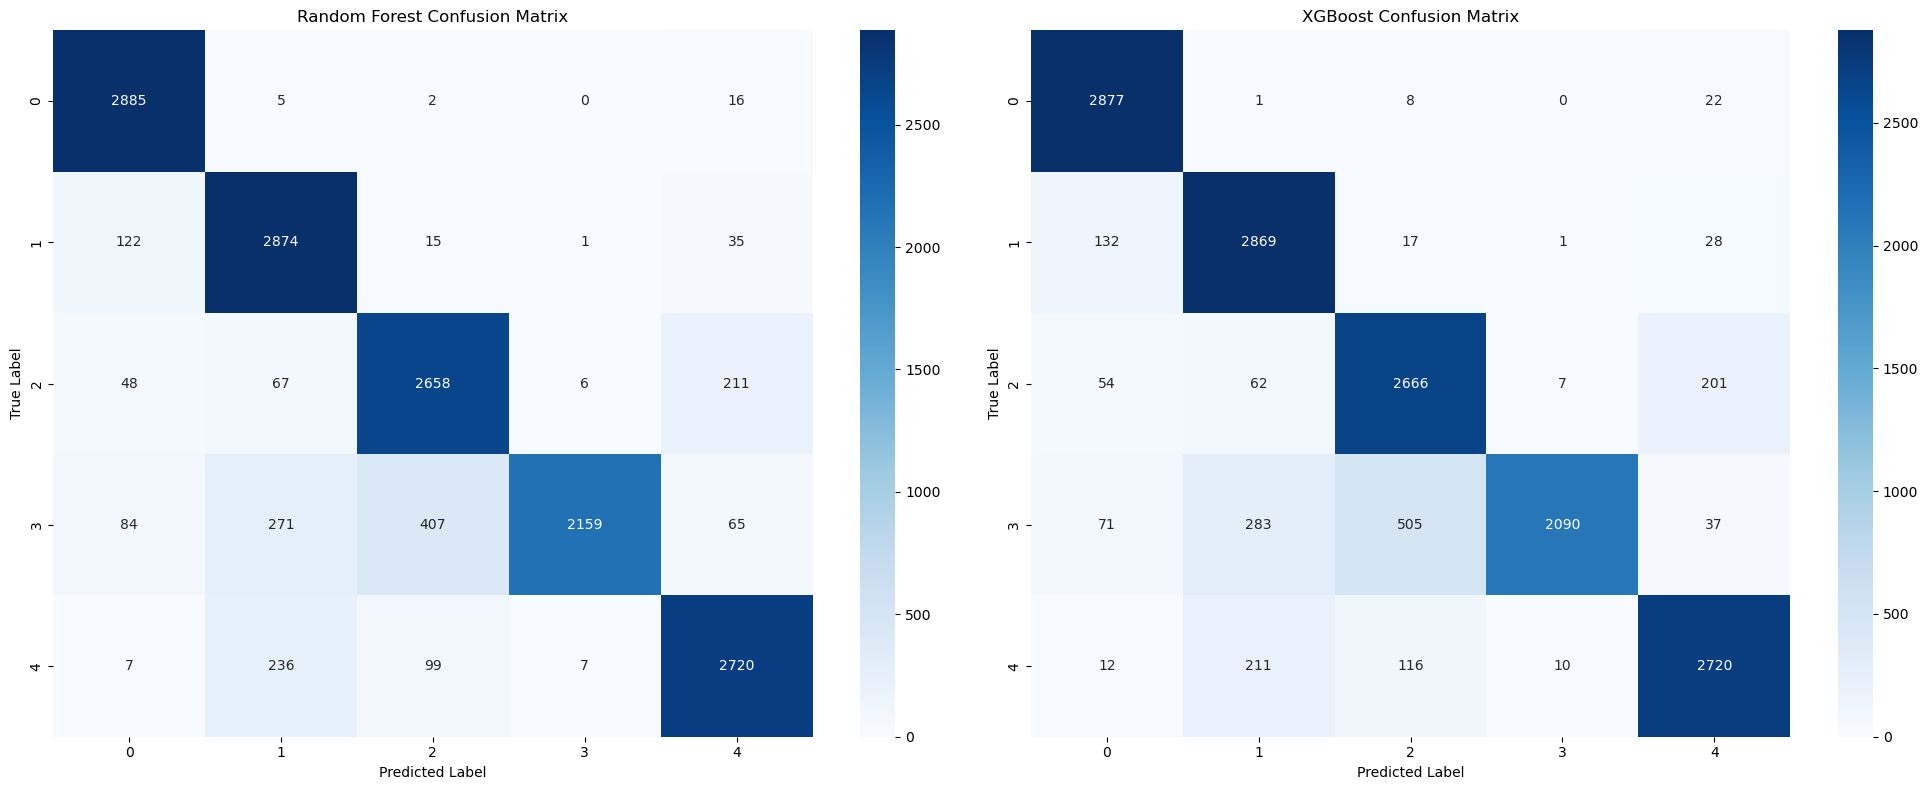

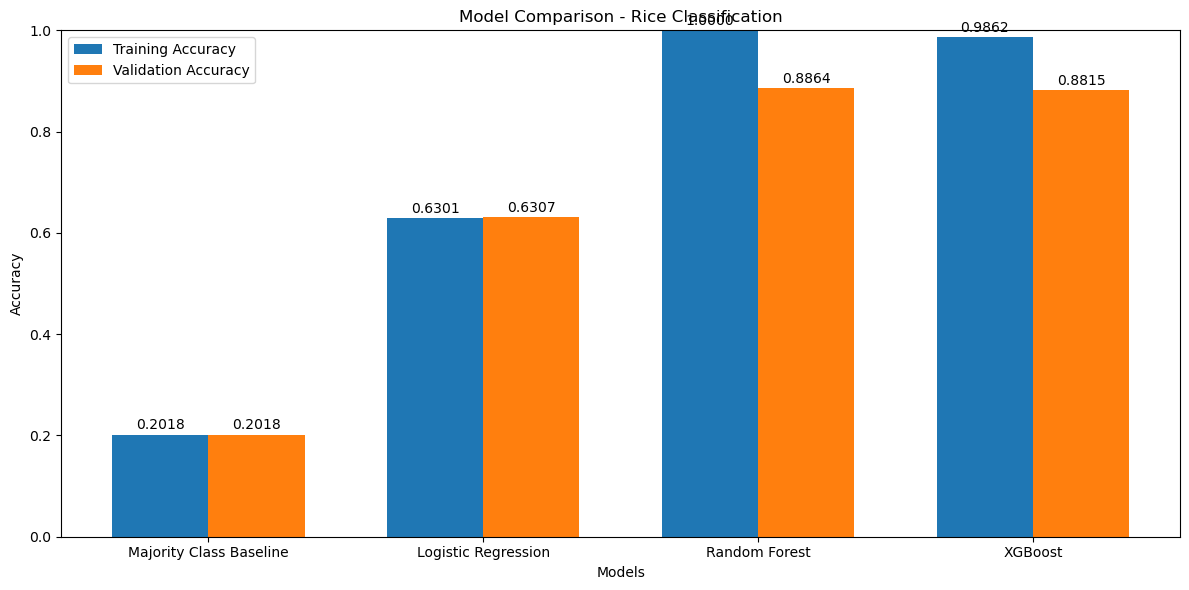


===== XGBoost Hyperparameter Tuning =====
Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.

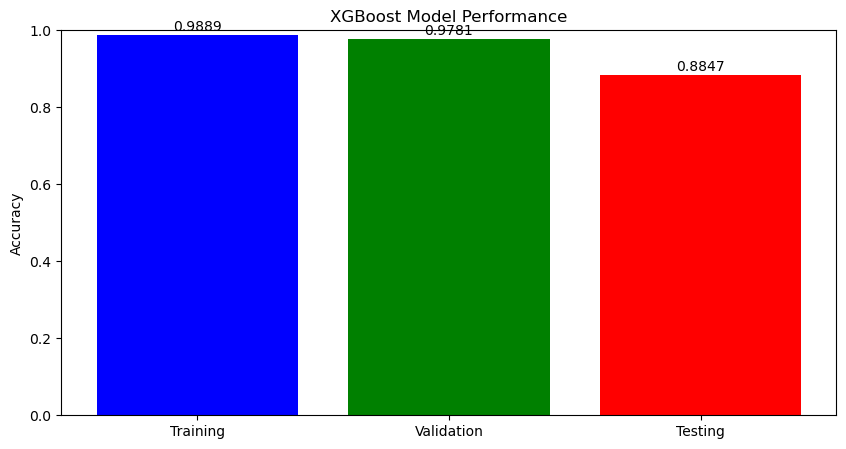

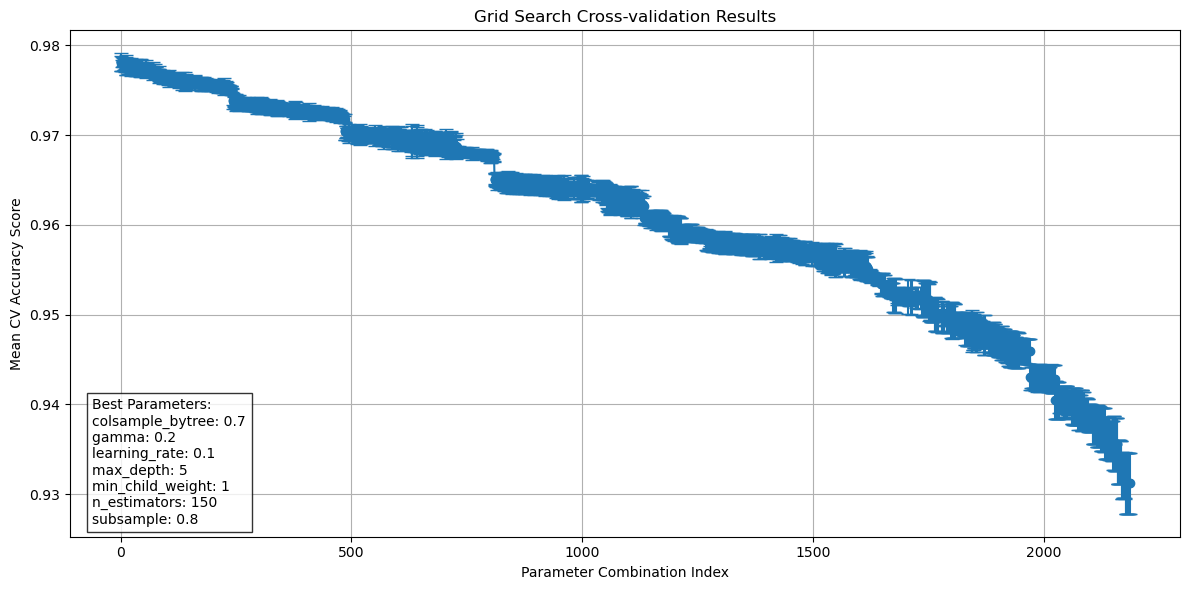


Detailed Grid Search Results:
Best score: 0.9781

Top 5 Parameter Combinations:

Rank 1:
Score: 0.9781 ± 0.0010
colsample_bytree: 0.7
gamma: 0.2
learning_rate: 0.1
max_depth: 5
min_child_weight: 1
n_estimators: 150
subsample: 0.8

Rank 2:
Score: 0.9780 ± 0.0008
colsample_bytree: 0.8
gamma: 0
learning_rate: 0.1
max_depth: 5
min_child_weight: 1
n_estimators: 150
subsample: 0.7

Rank 3:
Score: 0.9780 ± 0.0004
colsample_bytree: 0.7
gamma: 0
learning_rate: 0.1
max_depth: 5
min_child_weight: 1
n_estimators: 150
subsample: 0.7

Rank 4:
Score: 0.9779 ± 0.0008
colsample_bytree: 0.8
gamma: 0.2
learning_rate: 0.1
max_depth: 5
min_child_weight: 1
n_estimators: 150
subsample: 0.7

Rank 5:
Score: 0.9779 ± 0.0003
colsample_bytree: 0.7
gamma: 0.1
learning_rate: 0.1
max_depth: 5
min_child_weight: 1
n_estimators: 150
subsample: 0.7


In [61]:
print("\n===== XGBoost Classifier =====")
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax', 
    num_class=5, 
    random_state=1234,
    early_stopping_rounds=10, 
    n_jobs=-1 
)


xgb_model.fit(
    X_train_norm, 
    Y_train.values.ravel(),
    eval_set=[(X_val_norm, Y_val.values.ravel())],
    verbose=False
)


xgb_train_pred = xgb_model.predict(X_train_norm)
xgb_val_pred = xgb_model.predict(X_val_norm)
xgb_test_pred = xgb_model.predict(X_test_norm)

xgb_train_acc = accuracy_score(Y_train, xgb_train_pred)
xgb_val_acc = accuracy_score(Y_val, xgb_val_pred)
xgb_test_acc = accuracy_score(Y_test, xgb_test_pred)

print(f"XGBoost Training Accuracy: {xgb_train_acc:.4f}")
print(f"XGBoost Validation Accuracy: {xgb_val_acc:.4f}")
print(f"XGBoost Test Accuracy: {xgb_test_acc:.4f}")

print("\nXGBoost Classification Report (Validation Set):")
print(classification_report(Y_val, xgb_val_pred))

# Feature importance
plt.figure(figsize=(12, 8))
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_15_features = feature_importances.nlargest(15)
sns.barplot(x=top_15_features.values, y=top_15_features.index)
plt.title('Top 15 Most Important Features - XGBoost')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

## Confusion Matrices for Model Comparison

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(Y_val, rf_val_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(Y_val, xgb_val_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

## Model Performance Comparison

# Compare the performance of all models
models = ['Majority Class Baseline', 'Logistic Regression', 'Random Forest', 'XGBoost']
train_acc = [majority_class_accuracy, baseline_fit_hp.history['accuracy'][-1], rf_train_acc, xgb_train_acc]
val_acc = [majority_class_accuracy, baseline_fit_hp.history['val_accuracy'][-1], rf_val_acc, xgb_val_acc]

plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_acc, width, label='Training Accuracy')
plt.bar(x + width/2, val_acc, width, label='Validation Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Rice Classification')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1.0)

for i, v in enumerate(train_acc):
    plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center')
    
for i, v in enumerate(val_acc):
    plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Hyperparameter Tuning for XGBoost (Optional)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],          
    'max_depth': [3, 4, 5],                  
    'learning_rate': [0.01, 0.05, 0.1],      
    'subsample': [0.6, 0.7, 0.8],            
    'colsample_bytree': [0.6, 0.7, 0.8],     
    'min_child_weight': [1, 3, 5],           
    'gamma': [0, 0.1, 0.2]                  
}

print("\n===== XGBoost Hyperparameter Tuning =====")
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=5, random_state=1234),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train_norm, Y_train.values.ravel())

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

best_xgb_model = xgb.XGBClassifier(**grid_search.best_params_, objective='multi:softmax', num_class=5, random_state=1234)
best_xgb_model.fit(X_train_norm, Y_train.values.ravel())

best_xgb_val_pred = best_xgb_model.predict(X_val_norm)
best_xgb_val_acc = accuracy_score(Y_val, best_xgb_val_pred)
print(f"XGBoost with Best Parameters Validation Accuracy: {best_xgb_val_acc:.4f}")



# 1. Accuracy Comparison Bar Plot
plt.figure(figsize=(10, 5))
accuracies = {
    'Training': grid_search.best_estimator_.score(X_train_norm, Y_train.values.ravel()),
    'Validation': grid_search.best_score_,
    'Testing': best_xgb_val_acc
}

plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red'])
for i, (key, value) in enumerate(accuracies.items()):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center')

plt.title('XGBoost Model Performance')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.show()

# 2. Grid Search Results Plot
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(12, 6))

results = results.sort_values('mean_test_score', ascending=False)

plt.errorbar(range(len(results)), 
            results['mean_test_score'], 
            yerr=results['std_test_score'], 
            fmt='o-', 
            capsize=5)

plt.title('Grid Search Cross-validation Results')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean CV Accuracy Score')
plt.grid(True)

best_params_text = '\n'.join([f'{k}: {v}' for k, v in grid_search.best_params_.items()])
plt.text(0.02, 0.02, f'Best Parameters:\n{best_params_text}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='bottom')

plt.tight_layout()
plt.show()

print("\nDetailed Grid Search Results:")
print(f"Best score: {grid_search.best_score_:.4f}")
print("\nTop 5 Parameter Combinations:")
for i in range(5):
    print(f"\nRank {i+1}:")
    print(f"Score: {results['mean_test_score'].iloc[i]:.4f} ± {results['std_test_score'].iloc[i]:.4f}")
    params = results['params'].iloc[i]
    for key, value in params.items():
        print(f"{key}: {value}")